## Import necessary packages

In [1]:
# Utility and plotting:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Preprocessing:
from sklearn.preprocessing import StandardScaler

# Linear Regression:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest and Gradient Boost:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Read in the data:

In [2]:
df_import = pd.read_csv("insurance.csv")
df_import.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


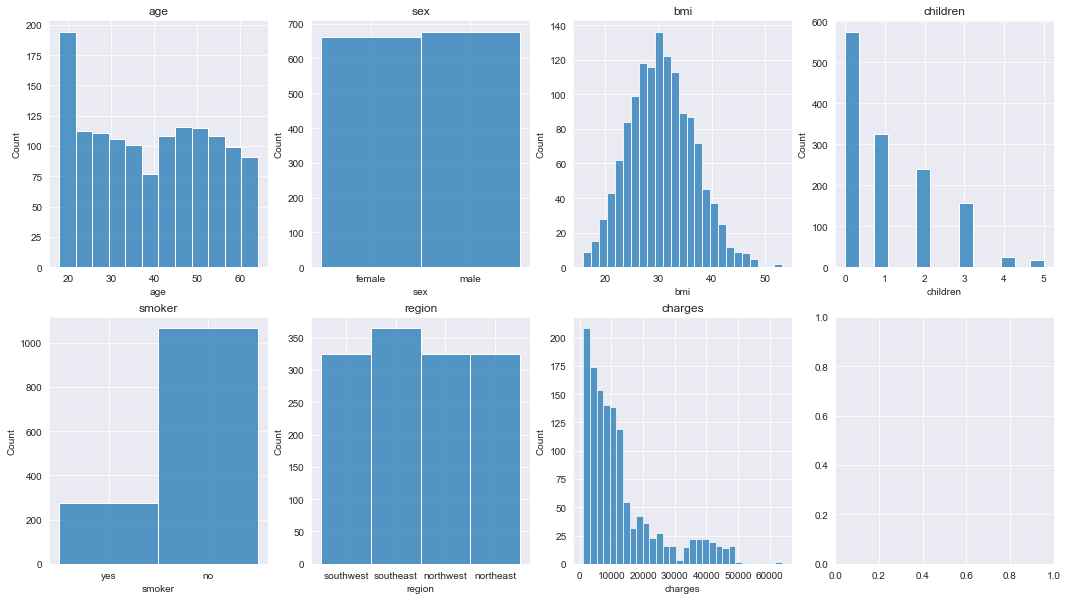

In [3]:
n_rows=2
n_cols=4

# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 10))
for i, column in enumerate(df_import):
    sns.histplot(df_import, x=column, ax=axes[i // n_cols, i % n_cols]).set_title(column)

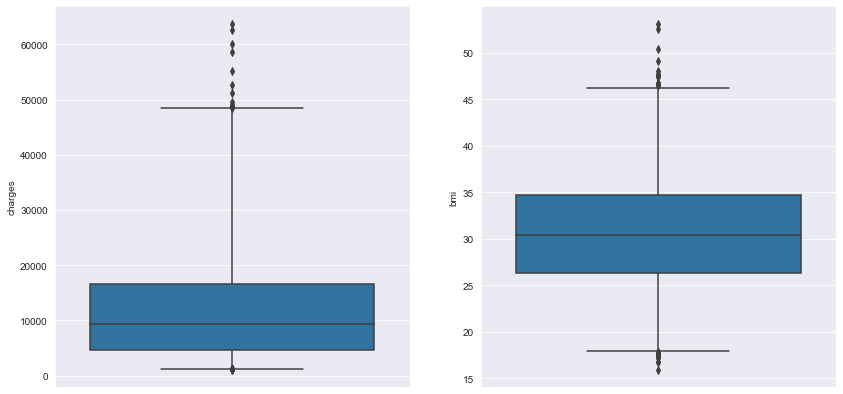

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.boxplot(data=df_import, y="charges", ax=ax[0], whis=(1, 99))
sns.boxplot(data=df_import, y="bmi", ax=ax[1], whis=(1, 99))
plt.show()

## Assess the quality of the data:

In [5]:
df_import.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df_summary = pd.DataFrame(df_import.isnull().sum()).transpose()
df_summary.index = ["Null values"]
df_summary

,age,sex,bmi,children,smoker,region,charges
Null values,0,0,0,0,0,0,0


In [7]:
df_summary = pd.DataFrame(df_import.dtypes).transpose()
df_summary.index = ["Data type"]
df_summary

,age,sex,bmi,children,smoker,region,charges
Data type,int64,object,float64,int64,object,object,float64


In [8]:
df_summary = pd.DataFrame(df_import.region.unique())
df_summary.columns = ["Region"]
df_summary

,Region
0,southwest
1,southeast
2,northwest
3,northeast


From the above tests we can see that there is no missing data, and we will have to convert 'sex', 'smoker' and 'region' into numerical data to proceed.

## Begin preprocessing:

Since there is no missing data, we can move straight to converting categorical data to numerical data.

In [9]:
class TrainingData:
    """
    Class to contain the pre-processing step, and retain any information required to reverse the
    pre-processing, which helps to understand the predictions.
    """
    _template = None
    def __init__(self, df):
        self._df = df
        self._template = None
    
        # Scalers:
        self.tg_scaler = StandardScaler()
        self.ft_scaler = StandardScaler()
        self.scaled_features = ["age", "bmi", "children"]
        
        # Execute pre-processing on initialisation:
        self.processed = self.preprocess()
        
    def preprocess(self, df=None):
        # Create a copy of the import DF:
        if df is None:
            df_process = self._df.copy()
        else:
            df_process = df.copy()

        # Convert catagorical data to numerical data:
        # Simply converting the sex and smoker columns to a 1 or 0 rather than a text value:
        df_process["male"] = df_process["sex"].apply(lambda x: 1 if x == "male" else 0)
        df_process["smoker"] = df_process["smoker"].apply(lambda x: 1 if x == "yes" else 0)

        # We can use the pd.get_dummies function to get multiple columns for each unique value of the region column:
        df_process = df_process.sort_values("region") # Sort to ensure the column names match the end value.
        df_process[df_process.region.unique()] = pd.get_dummies(df_process.region)
        
        # Apply Natural Log to the target variable:
        df_process["charges"] = np.log(df_process["charges"])

        # Remove unnecessary columns:
        df_process = df_process.drop(columns=["sex", "region"])
        
        # Formats the DataFrame so that the required columns are in the same order, this was if a single observation was
        # required, then just adding Region="Northwest" will still create a valid observation for the model as
        # Northeast/Southwest/Southeast will be added as columns with a value of 0:
        if df is None:
            self._template = list(df_process.columns)
        else:
            for col in self._template:
                if col not in df_process.columns:
                    df_process[col] = 0
            df_process = df_process[self._template]
            
        # Scale the features using StandardScaler:
        self.ft_scaler.fit(df_process[self.scaled_features])
        scaled_data = self.ft_scaler.transform(df_process[self.scaled_features].values)
        df_process[self.scaled_features] = scaled_data
        
        # Scale the target using StandardScaler:
        self.tg_scaler.fit(df_process["charges"].values.reshape(-1, 1))
        scaled_data = self.tg_scaler.transform(df_process["charges"].values.reshape(-1, 1))
        df_process["charges"] = scaled_data
        
        # Return a sorted DataFrame:
        return df_process.copy().sort_index() 
    
    def inverse(self, df=None, prediction_column=None):
        # Create a copy of the import DF:
        if df is None:
            df_process = self._df.copy()
        else:
            df_process = df.copy()
        
        # Get scaled columns:
        scaled_features = self.scaled_features
        
        # Reverse scaling:
        unscaled_data = self.ft_scaler.inverse_transform(df_process[scaled_features])
        df_process[scaled_features] = unscaled_data
        for col in ["charges", prediction_column]:
            unscaled_data = self.tg_scaler.inverse_transform(df_process[col].values.reshape(-1, 1))
            df_process[col] = unscaled_data
        
        # Reverse log:
        df_process["charges"] = np.exp(df_process.charges)
        if prediction_column:
            df_process[prediction_column] = np.exp(df_process[prediction_column])
        
        return df_process.copy().sort_index()
        
    def _repr_html_(self):
        return self.processed._repr_html_()

In [10]:
td = TrainingData(df_import)
td.processed.head()

,age,bmi,children,smoker,charges,male,northeast,northwest,southeast,southwest
0,-1.438764,-0.453320,-0.908614,1,0.691394,0,0,0,0,1
1,-1.509965,0.509621,-0.078767,0,-1.790020,1,0,0,1,0
2,-0.797954,0.383307,1.580926,0,-0.759500,1,0,0,1,0
3,-0.441948,-1.305531,-0.908614,0,0.978513,1,0,1,0,0
4,-0.513149,-0.292556,-0.908614,0,-0.912181,1,0,1,0,0


## Data Analysis and Exploration following processing:

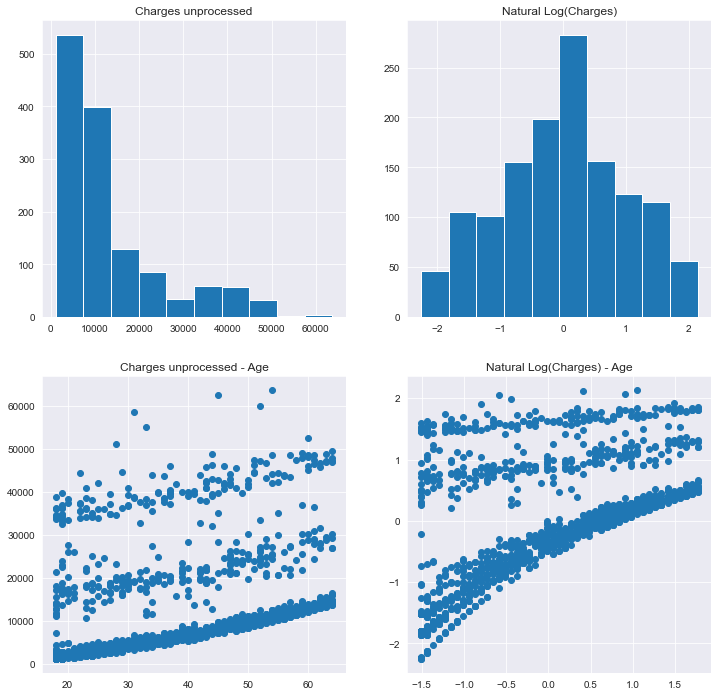

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0][0].hist(df_import.charges)
axs[0][0].set_title("Charges unprocessed")
axs[0][1].hist(td.processed.charges)
axs[0][1].set_title("Natural Log(Charges)")
axs[1][0].scatter(df_import.age, df_import.charges)
axs[1][0].set_title("Charges unprocessed - Age")
axs[1][1].scatter(td.processed.age, td.processed.charges)
axs[1][1].set_title("Natural Log(Charges) - Age")

plt.show()

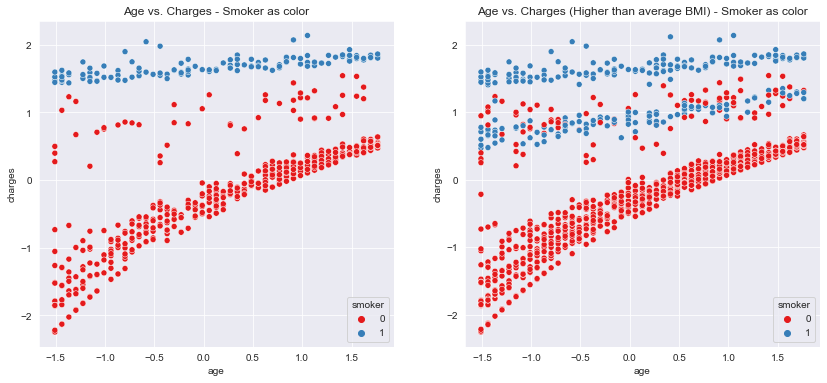

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# No filter applied:
df_query = td.processed.query("bmi > 0")
sns.scatterplot(x=df_query.age, y=df_query.charges, hue=df_query.smoker, palette="Set1", ax=axs[0])
axs[0].set_title("Age vs. Charges - Smoker as color")

# Above mean BMI:
df_query = td.processed.query("bmi < 30.663397")
sns.scatterplot(x=df_query.age, y=df_query.charges, hue=df_query.smoker, palette="Set1", ax=axs[1])
axs[1].set_title("Age vs. Charges (Higher than average BMI) - Smoker as color")

plt.show()

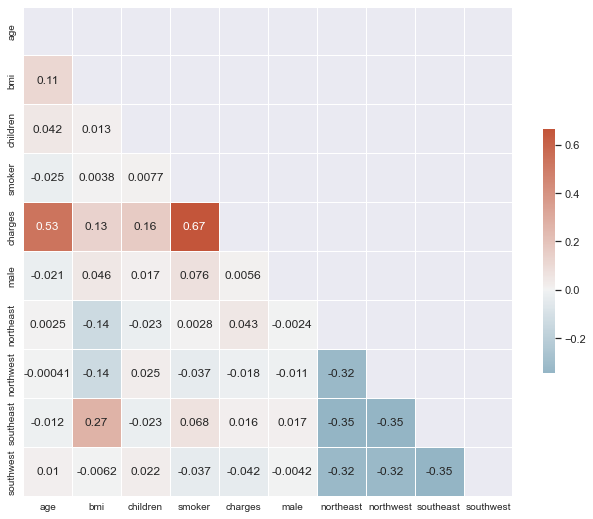

In [13]:
# Compute the correlation matrix
corr = td.processed.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=np.where(~mask, corr, 0).max(), center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

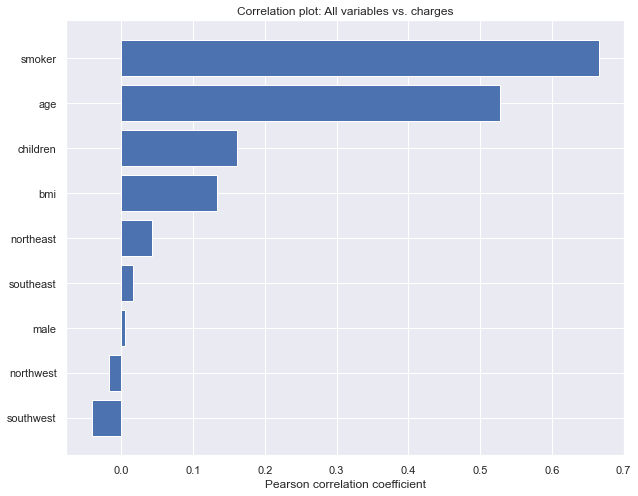

In [14]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, figsize=(10, 8))
variable = "charges"
corr_ndir = (corr
        .sort_values(variable)
        .drop(variable, axis=0)
        .filter([variable], axis=1)
       )
ax.barh(corr_ndir.index, corr_ndir[variable].values)
ax.set_title(f"Correlation plot: All variables vs. {variable}")
ax.set_xlabel(f"Pearson correlation coefficient")

plt.show()

## Create models:

### Linear Regression
Rather than parameter tuning, we are using every combination of the various features (using a cartesian join) to see which combination of the features provides the highest accuracy model:

In [15]:
data = []

df = td.processed.copy()
y_labels = ["charges"]
x_labels = list(df.drop(columns=y_labels).columns)

def train_linear(x_labels, y_labels):
    
    X = df[x_labels].values
    Y = df[y_labels].values.ravel()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    model = linear_model.LinearRegression()
    
    try:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = r2_score(Y_test, Y_pred)
        
    except ValueError:
        mse = np.NaN
        r2 = np.NaN
        
        
    return {
        "x_labels": x_labels,
        "mse": mse,
        "r2": r2,
        "model": model
    }
    
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr.reshape(-1, la)

array = np.array([1, 0])
label_combinations = cartesian_product(*[array for _ in x_labels])

for i, combination in enumerate(label_combinations):
    print(i, end="\r")       
    x_label_combination = [x_labels[i] for i, value in enumerate(combination) if value == 1]
    data.append(train_linear(x_label_combination, y_labels))

df_error = pd.DataFrame(data).sort_values("r2", ascending=False).reset_index(drop=True)
df_error.head()

,x_labels,mse,r2,model
0,"[age, bmi, children, smoker, male, northwest, ...",0.207805,0.804731,"LinearRegression(copy_X=True, fit_intercept=Tr..."
1,"[age, bmi, children, smoker, male, northeast, ...",0.207805,0.804731,"LinearRegression(copy_X=True, fit_intercept=Tr..."
2,"[age, bmi, children, smoker, male, northeast, ...",0.207805,0.804731,"LinearRegression(copy_X=True, fit_intercept=Tr..."
3,"[age, bmi, children, smoker, male, northeast, ...",0.207805,0.804731,"LinearRegression(copy_X=True, fit_intercept=Tr..."
4,"[age, bmi, children, smoker, male, northeast, ...",0.207805,0.804731,"LinearRegression(copy_X=True, fit_intercept=Tr..."


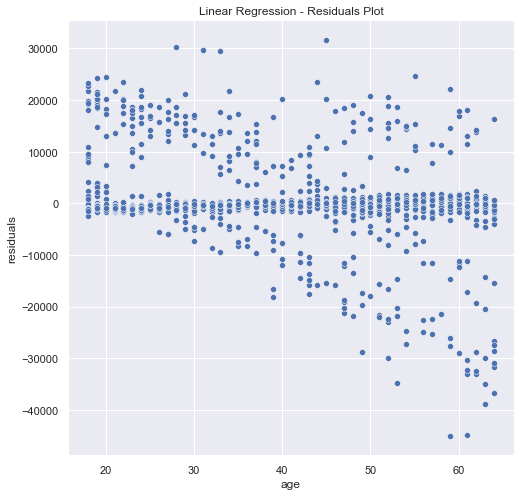

In [16]:
# Get x-labels from the highest performing model:
x_labels = df_error.iloc[0]["x_labels"]
y_labels = ["charges"]

model_data = train_linear(x_labels, y_labels)
model = model_data["model"]

df_pred = td.processed.copy()

X = df_pred[x_labels].values
df_pred["predict_charges"] = model.predict(X)
df1 = td.inverse(df_pred, "predict_charges")
df1["residuals"] = df1.charges - df1.predict_charges
df1


fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=df1.age, y=df1.residuals)
ax.set_title("Linear Regression - Residuals Plot")

plt.show()

In [17]:
model.__dict__

print("The Linear Regression model is defined as:")
print(f"y = {model.intercept_:.3f} {' + '.join([f'x{i+1}*{x:.3f}' for i, x in enumerate(model.coef_)])}")

The Linear Regression model is defined as:
y = -0.208 x1*0.523 + x2*0.090 + x3*0.121 + x4*1.688 + x5*-0.081 + x6*-0.061 + x7*-0.148 + x8*-0.133


### Random Forest Regression

In [31]:
df = td.processed.copy()
y_labels = ["charges"]
x_labels = list(df.drop(columns=y_labels).columns)

X = df[x_labels].values
Y = df[y_labels].values.ravel()

param_grid = {
    'n_estimators': range(200, 410, 50),
    'max_depth': range(6, 10),
    'min_samples_split': range(0, 7),
    'max_features': range(4, 8)
}

base_estimator = RandomForestRegressor(random_state=42)
sh = GridSearchCV(
    base_estimator,
    param_grid,
    cv=2,
    verbose=1,
    n_jobs=10
).fit(X, Y)

sh.best_estimator_

Fitting 2 folds for each of 560 candidates, totalling 1120 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   16.4s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   29.8s
[Parallel(n_jobs=10)]: Done 1120 out of 1120 | elapsed:   44.1s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [32]:
results = pd.DataFrame(sh.cv_results_).sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
59,0.563345,0.002001,0.037534,5.000830e-04,6,5,4,400,"{'max_depth': 6, 'max_features': 5, 'min_sampl...",0.824640,0.835242,0.829941,0.005301,1
58,0.496596,0.007507,0.033030,2.384186e-07,6,5,4,350,"{'max_depth': 6, 'max_features': 5, 'min_sampl...",0.824885,0.834887,0.829886,0.005001,2
47,0.431391,0.002002,0.029027,1.000881e-03,6,5,2,300,"{'max_depth': 6, 'max_features': 5, 'min_sampl...",0.824032,0.835473,0.829753,0.005721,3
45,0.292265,0.005004,0.020019,4.768372e-07,6,5,2,200,"{'max_depth': 6, 'max_features': 5, 'min_sampl...",0.823433,0.836036,0.829734,0.006302,4
46,0.357325,0.004004,0.022521,5.007982e-04,6,5,2,250,"{'max_depth': 6, 'max_features': 5, 'min_sampl...",0.823600,0.835838,0.829719,0.006119,5


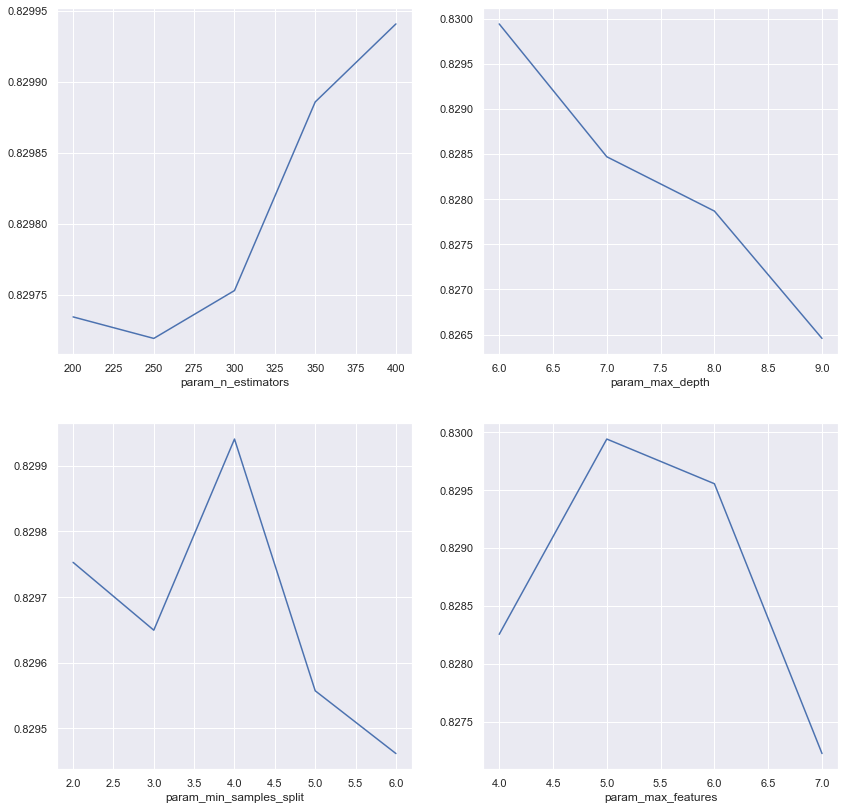

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

for i, key in enumerate(param_grid.keys()):
    row = math.floor((i/2) % 2)
    col = i % 2
    results.groupby(f"param_{key}")["mean_test_score"].max().plot(ax=axs[row][col])
    
plt.show()

In [34]:
df["predict_charges"] = sh.best_estimator_.predict(X)
df2 = td.inverse(df, "predict_charges")
df2["residuals"] = df2.charges - df2.predict_charges
df2

,age,bmi,children,smoker,charges,male,northeast,northwest,southeast,southwest,predict_charges,residuals
0,19.0,27.900,0.0,1,16884.92400,0,0,0,0,1,17446.693945,-561.769945
1,18.0,33.770,1.0,0,1725.55230,1,0,0,1,0,2538.592323,-813.040023
2,28.0,33.000,3.0,0,4449.46200,1,0,0,1,0,5081.825783,-632.363783
3,33.0,22.705,0.0,0,21984.47061,1,0,1,0,0,5776.075224,16208.395386
4,32.0,28.880,0.0,0,3866.85520,1,0,1,0,0,3774.426147,92.429053
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3.0,0,10600.54830,1,0,1,0,0,11425.080864,-824.532564
1334,18.0,31.920,0.0,0,2205.98080,0,1,0,0,0,2698.295504,-492.314704
1335,18.0,36.850,0.0,0,1629.83350,0,0,0,1,0,2219.189629,-589.356129
1336,21.0,25.800,0.0,0,2007.94500,0,0,0,0,1,2266.480598,-258.535598


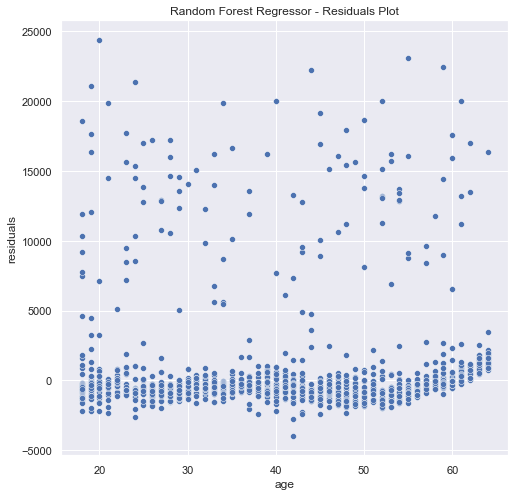

In [35]:
df_res = df2.query('residuals < 5000')

fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=df2.age, y=df2.residuals)
ax.set_title("Random Forest Regressor - Residuals Plot")

plt.show()

### Gradient Boosting Regression:

In [37]:
df = td.processed.copy()
y_labels = ["charges"]
x_labels = list(df.drop(columns=y_labels).columns)

X = df[x_labels].values
Y = df[y_labels].values.ravel()

# Get a list of values to be used in param_grid:
def get_range(low, high, step=1, n_type=int):
    return [n_type(x) for x in range(low, high+step, step)]

param_grid = {
    'n_estimators': get_range(300, 600, 50),
    'learning_rate': np.linspace(0.005, 0.075, 5),
    'max_depth': get_range(1, 5)
}

base_estimator = GradientBoostingRegressor(random_state=42, learning_rate=0.01)
gb = GridSearchCV(
    base_estimator,
    param_grid,
    cv=5,
    verbose=1,
    n_jobs=10
).fit(X, Y)

gb.best_estimator_

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   31.6s
[Parallel(n_jobs=10)]: Done 875 out of 875 | elapsed:   36.9s finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.0225, loss='ls',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
results = pd.DataFrame(gb.cv_results_).sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.252188,0.001604,0.001914,0.000655,0.0225,3,300,"{'learning_rate': 0.0225, 'max_depth': 3, 'n_e...",0.883229,0.739231,0.905188,0.844690,0.807448,0.835957,0.058775,1
50,0.294547,0.003138,0.002006,0.000623,0.0225,3,350,"{'learning_rate': 0.0225, 'max_depth': 3, 'n_e...",0.879883,0.737863,0.904889,0.843800,0.805911,0.834469,0.058748,2
51,0.335832,0.003872,0.002402,0.000490,0.0225,3,400,"{'learning_rate': 0.0225, 'max_depth': 3, 'n_e...",0.877312,0.736742,0.904604,0.843058,0.805147,0.833373,0.058707,3
45,0.272755,0.001899,0.001601,0.000490,0.0225,2,450,"{'learning_rate': 0.0225, 'max_depth': 2, 'n_e...",0.884311,0.738884,0.899647,0.835746,0.807873,0.833292,0.057569,4
46,0.301779,0.002777,0.001602,0.000490,0.0225,2,500,"{'learning_rate': 0.0225, 'max_depth': 2, 'n_e...",0.883840,0.738188,0.900300,0.836376,0.807218,0.833184,0.057930,5


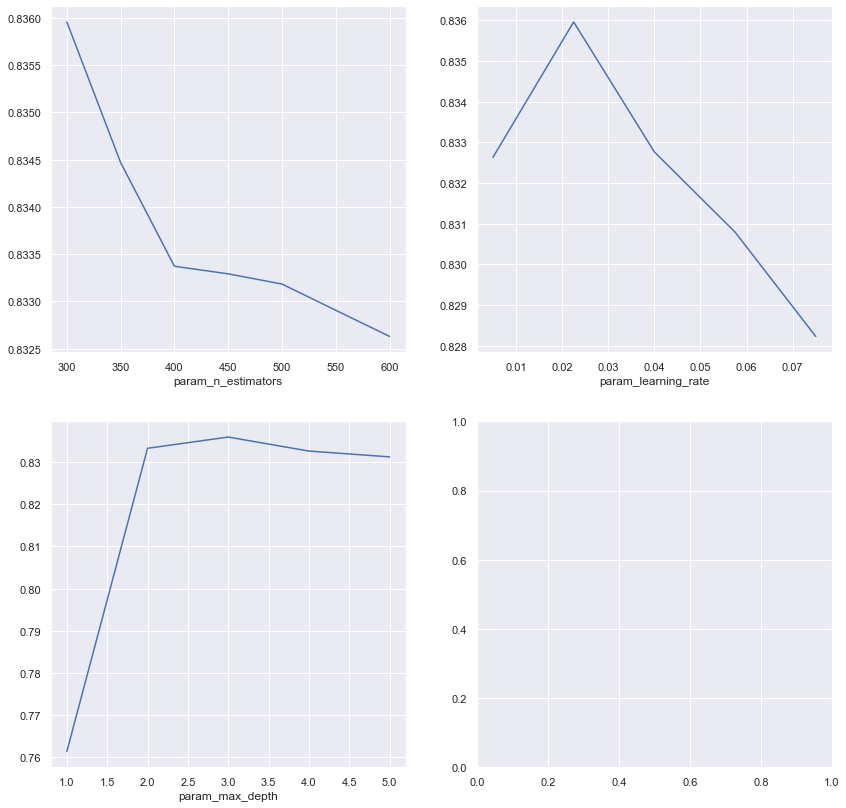

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

for i, key in enumerate(param_grid.keys()):
    row = math.floor((i/2) % 2)
    col = i % 2
    results.groupby(f"param_{key}")["mean_test_score"].max().plot(ax=axs[row][col])

In [40]:
df["predict_charges"] = gb.best_estimator_.predict(X)
df3 = td.inverse(df, "predict_charges")
df3["charges_residuals"] = df3.charges - df3.predict_charges
df3

,age,bmi,children,smoker,charges,male,northeast,northwest,southeast,southwest,predict_charges,charges_residuals
0,19.0,27.900,0.0,1,16884.92400,0,0,0,0,1,18484.082971,-1599.158971
1,18.0,33.770,1.0,0,1725.55230,1,0,0,1,0,2164.733026,-439.180726
2,28.0,33.000,3.0,0,4449.46200,1,0,0,1,0,5211.167194,-761.705194
3,33.0,22.705,0.0,0,21984.47061,1,0,1,0,0,5405.490404,16578.980206
4,32.0,28.880,0.0,0,3866.85520,1,0,1,0,0,3929.871518,-63.016318
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50.0,30.970,3.0,0,10600.54830,1,0,1,0,0,11270.629635,-670.081335
1334,18.0,31.920,0.0,0,2205.98080,0,1,0,0,0,2709.771398,-503.790598
1335,18.0,36.850,0.0,0,1629.83350,0,0,0,1,0,2071.876588,-442.043088
1336,21.0,25.800,0.0,0,2007.94500,0,0,0,0,1,2237.479818,-229.534818


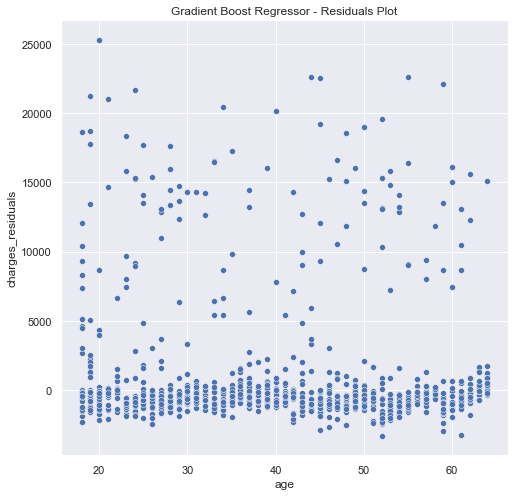

In [41]:
fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x=df3.age, y=df3.charges_residuals)
ax.set_title("Gradient Boost Regressor - Residuals Plot")

plt.show()